In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
ls

 Annotation.txt   cells_expressions.tsv  'Текст задания.docx'
 README.md        notebook.ipynb


In [222]:
!head -n 2 README.md

Есть таблица с экспрессиями (название образца обычно начинается с SRR или ERR) для образцов сортированных клеток. В этой таблице экспрессии ряда генов для каждого образца. В таблице только некоторые гены, чтобы она была небольшой (обычно бывает 20 - 40 тыс разных генов). Ещё есть аннотация, в которой указано, какому типу клеток соответствует образец (колонка general_cell_type, каждый SRR соответствует определённому типу клеток, T_cells, NK_cells и т. д.). Необходимо, опираясь на эту аннотацию, сделать смеси из экспрессий этих клеток. Для каждой смеси выбирается случайный образец каждого типа клеток. Затем экспрессии этих образцов смешиваются в случайных соотношениях, например 0.1*CD4_T_cells + 0.2*B_cells  +... = mix_1. Смесь делается при помощи линейной комбинации векторов экспрессий. Сумма этих коэффициентов (долей клеток) перед векторами должна быть равна 1, коэффициенты должны быть случайными числами. CD4_T_cells в формуле обозначает вектор экспрессий определённого образца данного 

In [285]:
def read_annotations(filename='Annotation.txt'):
    df = pd.read_csv('Annotation.txt', sep='\t', index_col=0)
    return df

def read_expressions(filename='cell_expressions.tsv'):
    df = pd.read_csv('cells_expressions.tsv', sep='\t', index_col=0)
    return df

annotations = read_annotations()
expressions = read_expressions()
n_cell_types = len(annotations.Cell_type.unique())

def vec_coordinates(n=1):
    vec = np.random.uniform(size=n_cell_types)
    vec = vec / vec.sum()
    return vec

from collections import defaultdict
available_expressions = set(expressions.T.index.unique())
cell_types_lookup = defaultdict(lambda: [])
for sample_id, cell_type in annotations.loc[:, 'Cell_type'].items():
    if sample_id in available_expressions:
        cell_types_lookup[cell_type].append(sample_id)

def choose_samples(expressions=expressions, annotations=annotations):
    from random import choice

    rv = {}
    for cell_type, available_samples in cell_types_lookup.items():
        rv[cell_type] = choice(available_samples)
        
    return rv


def random_sample_expressions(n_samples=1_000):
    rv = []
    ground_truth = []

    i = 0
    while i < n_samples:
        l = list(choose_samples().values())
        d = expressions.T.loc[l]
        v = vec_coordinates()
        df = pd.DataFrame(v@d, columns=[f'mix_{i}']).sort_index()
        
        # check that there are no NaN values
        if df.isna().sum().values[0]:
            continue

        rv.append(df)
        ground_truth.append((l, v))
        i += 1

    samples = pd.concat(rv, axis=1)
    return samples, ground_truth

In [273]:
!tail -n+4 README.md | head -n 3

Затем необходимо построить таблицу корреляций каждого гена с замешанным количеством клеток для каждого типа клеток по смесям. В итоговой таблице индексы – названия генов, колонки - типы клеток, на пересечении величины коэффициентов корреляции Пирсона.  Дополнительно можно визуализировать данную таблицу с помощью heatmap или clustermap.

Если в начальном варианте получится, что редко встречаются доли клеток в 70% и более, то необходимо написать такую генерацию распределений долей клеток, чтобы каждого типа клеток в смесях присутствовало от нуля до 100%


In [357]:
from scipy.stats import pearsonr

s, gt = random_sample_expressions()

def cell_type_by_sample(sample):
    return annotations.loc[sample].Cell_type

cell_types_gt = defaultdict(lambda: [])
for samples, components in gt:
    for sample, component in zip(samples, components):
        cell_type = cell_type_by_sample(sample)
        cell_types_gt[cell_type].append(component)

corrs = pd.DataFrame(index=s.index, columns=cell_types_gt.keys())

for cell_type in cell_types_gt:
    for gene in s.index:
        genes_v = s.loc[gene].values
        celltypes_v = np.array(cell_types_gt[cell_type])
        
        r, _ = pearsonr(genes_v, celltypes_v)
        corrs.loc[gene, cell_type] = r
corrs = corrs.astype('float')

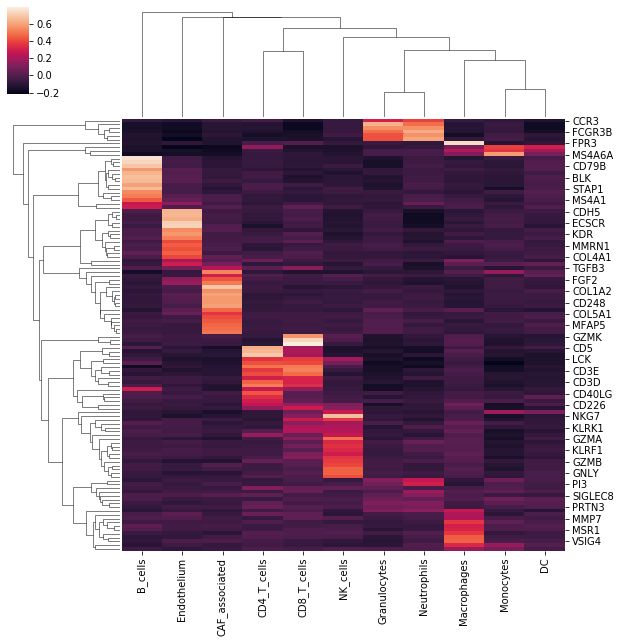

In [358]:
sns.clustermap(corrs)

In [355]:
!tail -3 README.md | head -1

Дополнительный пункт задания: обучить линейные модели, вычисляющие долю каждого типа клеток по экспрессиям смеси. Для моделей выбрать оптимальный набор генов из представленных и выбрать оптимальные параметры регуляризации. Обосновать набор параметров и генов. 


In [572]:
# construct X and y arrays
N = 10_000

s, gt = random_sample_expressions(1_000)

X = s.T.values
y = np.array([pair[1] for pair in gt])
X.shape, y.shape

((1000, 114), (1000, 11))

In [573]:
from sklearn.linear_model import MultiTaskLassoCV, RidgeCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# hold out (Xv, yv) pair
Xt, Xv, yt, yv = train_test_split(X, y, random_state=0)

In [574]:
# let's test Lasso first

In [575]:
lcv = MultiTaskLassoCV(n_alphas=100, n_jobs=8, cv=11, max_iter=2_000)
lcv.fit(Xt, yt)

lcv.score(Xv, yv)

0.6720616548117633

In [576]:
lcv.predict(Xv[0].reshape(1,-1))

array([[0.09507474, 0.12796432, 0.10981951, 0.13085756, 0.04400297,
        0.07290936, 0.04635086, 0.13813568, 0.08881864, 0.04172395,
        0.10434241]])

In [577]:
yv[0]

array([0.09270851, 0.11677278, 0.10020143, 0.14428131, 0.00854114,
       0.10309474, 0.03794912, 0.17679245, 0.09337387, 0.00662119,
       0.11966347])

In [578]:
# what about RidgeCV?

In [579]:
rcv = RidgeCV(alphas=np.linspace(-5,5,25), cv=11)

In [580]:
rcv.fit(Xt, yt)

RidgeCV(alphas=array([-5.        , -4.58333333, -4.16666667, -3.75      , -3.33333333,
       -2.91666667, -2.5       , -2.08333333, -1.66666667, -1.25      ,
       -0.83333333, -0.41666667,  0.        ,  0.41666667,  0.83333333,
        1.25      ,  1.66666667,  2.08333333,  2.5       ,  2.91666667,
        3.33333333,  3.75      ,  4.16666667,  4.58333333,  5.        ]),
        cv=11)

In [581]:
rcv.best_score_

0.7069544305546495

In [582]:
rcv.score(Xv, yv)

0.7046503586064665

In [583]:
rcv.predict(Xv[0].reshape(1,-1))

array([[0.09418307, 0.13074033, 0.10094153, 0.13175783, 0.07355941,
        0.05977788, 0.04460648, 0.12049508, 0.08419884, 0.04517515,
        0.11456441]])

In [584]:
yv[0]

array([0.09270851, 0.11677278, 0.10020143, 0.14428131, 0.00854114,
       0.10309474, 0.03794912, 0.17679245, 0.09337387, 0.00662119,
       0.11966347])

Looks like both linear models are more or less comparable in quality.
Let's visualize that:

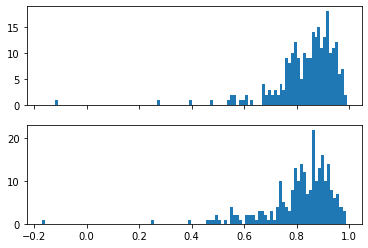

In [585]:
rcv_corrs = [pearsonr(l, r) for l, r in zip(yv, rcv.predict(Xv))]
lcv_corrs = [pearsonr(l, r) for l, r in zip(yv, lcv.predict(Xv))]

data = pd.DataFrame(
    {
        'ridge':[elem[0] for elem in rcv_corrs],
        'lasso':[elem[0] for elem in lcv_corrs],
    }
)

fig, ax = plt.subplots(2, sharex=True)

ax[0].hist(data['ridge'].values, bins=100, label='ridge')
ax[1].hist(data['lasso'].values, bins=100, label='lasso');

In [586]:
data.describe()

,ridge,lasso
count,250.000000,250.000000
mean,0.836407,0.812100
std,0.120801,0.134250
min,-0.119031,-0.169411
25%,0.790753,0.770190
50%,0.863753,0.838739
75%,0.914092,0.897587
max,0.990624,0.986892


Looks like that Ridge regression outperforms Lasso:
    - mean & median Pearson correlation with target cell component types are larger
    - less outliers (min is larger, 25th percentile as well)

Let's try to join both methods: select feature by Lasso and use only them in Ridge

In [587]:
(lcv.coef_ == 0).sum(), (lcv.coef_.shape[0] * lcv.coef_.shape[1])

(341, 1254)

Roughly quarter of all coefficients are 0. What if we ignore them in Ridge?

In [588]:
(lcv.coef_ != 0).sum(axis=0)

array([11,  0, 11, 11, 11, 11, 11,  0, 11, 11,  0, 11,  0, 11,  0, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  0, 11, 11, 11, 11,
       11, 11, 11, 11,  0,  0, 11, 11, 11, 11, 11,  0,  0, 11, 11,  0, 11,
       11,  0, 11,  0, 11,  0, 11, 11, 11, 11, 11, 11, 11,  0, 11, 11, 11,
        0,  0, 11, 11, 11, 11, 11, 11,  0, 11, 11,  0, 11, 11, 11, 11,  0,
       11,  0, 11, 11, 11,  0, 11,  0, 11, 11,  0, 11,  0,  0,  0,  0, 11,
       11,  0, 11, 11, 11,  0,  0, 11, 11, 11, 11, 11])

In [589]:
genes_upd = [gene for gene, val in zip(s.index, (lcv.coef_ != 0).sum(axis=0)) if val > 0]
len(genes_upd)

83

Let's use them to construct X array again, and train RidgeCV only

In [590]:
s_upd = s.loc[genes_upd]

# construct X and y arrays
s_upd = s.loc[genes_upd]

X = s_upd.T.values
y = np.array([pair[1] for pair in gt])
X.shape, y.shape

((1000, 83), (1000, 11))

In [591]:
Xt, Xv, yt, yv = train_test_split(X, y, random_state=0)
rcv = RidgeCV(alphas=np.linspace(-5,5,25), cv=11)

In [592]:
rcv = RidgeCV(alphas=np.linspace(-5,5,25), cv=11)
rcv.fit(Xt, yt)

rcv.best_score_
rcv.score(Xv, yv)

0.6722735301284968

Doesn't help, meaning that all features were valuable. Well, at least we tried :)

In [593]:
!tail -2 README.md

Второй дополнительный пункт задания: обучить нелинейные модели для этого (например, Random Forest). Для моделей выбрать оптимальный набор генов из представленных и выбрать оптимальные гиперпараметры обучения. Обосновать набор параметров и генов. 



Lets compare our fine-tuned (a little bit) Ridge with simple non-linear model, RandomForest.
For simplicity, we'll use max_depth=2, n_estimators=100.

In [608]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

X = s.T.values
y = np.array([pair[1] for pair in gt])
X.shape, y.shape
Xt, Xv, yt, yv = train_test_split(X, y, random_state=0)

max_depth=5
n_estimators=150
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          random_state=0),
                                   n_jobs=8)

regr_multirf.fit(Xt, yt)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=5,
                                                     n_estimators=150,
                                                     random_state=0),
                     n_jobs=8)

In [609]:
regr_multirf.score(Xv, yv)

0.6709557655759485

In [610]:
regr_multirf.predict(Xv[0].reshape(1,-1))

array([[0.10511329, 0.12565954, 0.10327488, 0.14905776, 0.06317358,
        0.05164639, 0.08059443, 0.12848625, 0.11485498, 0.01531404,
        0.08569659]])

In [611]:
yv[0]

array([0.09270851, 0.11677278, 0.10020143, 0.14428131, 0.00854114,
       0.10309474, 0.03794912, 0.17679245, 0.09337387, 0.00662119,
       0.11966347])

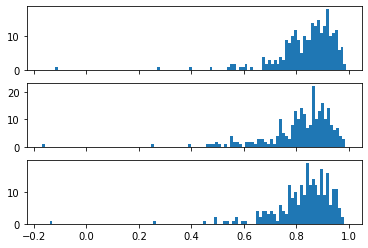

In [612]:
rcv = RidgeCV(alphas=np.linspace(-5,5,25), cv=11)
rcv.fit(Xt, yt)

rcv_corrs = [pearsonr(l, r) for l, r in zip(yv, rcv.predict(Xv))]
lcv_corrs = [pearsonr(l, r) for l, r in zip(yv, lcv.predict(Xv))]
rf_corrs = [pearsonr(l, r) for l, r in zip(yv, regr_multirf.predict(Xv))]

data = pd.DataFrame(
    {
        'ridge':[elem[0] for elem in rcv_corrs],
        'lasso':[elem[0] for elem in lcv_corrs],
        'RF_multi':[elem[0] for elem in rf_corrs],
    }
)

fig, ax = plt.subplots(3, sharex=True)

ax[0].hist(data['ridge'].values, bins=100, label='ridge')
ax[1].hist(data['lasso'].values, bins=100, label='lasso')
ax[2].hist(data['RF_multi'].values, bins=100, label='RF_multi');

In [613]:
data.describe()

,ridge,lasso,RF_multi
count,250.000000,250.000000,250.000000
mean,0.836407,0.812100,0.824869
std,0.120801,0.134250,0.121255
min,-0.119031,-0.169411,-0.140866
25%,0.790753,0.770190,0.780264
50%,0.863753,0.838739,0.846496
75%,0.914092,0.897587,0.902137
max,0.990624,0.986892,0.981445


Ridge regresssion outperforms even simple nonlinear model, meaning that we better stick with it for some time.